## Task 3




### Importing libraries

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score, silhouette_score
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

### Loading Data

In [2]:
customers = pd.read_csv('Customers.csv')
products = pd.read_csv('Products.csv')
transactions = pd.read_csv('Transactions.csv')

### Checking data types

In [3]:
customers['SignupDate'] = pd.to_datetime(customers['SignupDate'])
transactions['TransactionDate'] = pd.to_datetime(transactions['TransactionDate'])


### Merging Data

In [4]:
merged_data = pd.merge(transactions, customers, on='CustomerID')
merged_data = pd.merge(merged_data, products, on='ProductID')

### Feature engineering

In [5]:
customer_features = merged_data.groupby('CustomerID').agg(
    TotalSpending=('TotalValue', 'sum'),
    TransactionCount=('TransactionID', 'nunique'),
    AvgTransactionValue=('TotalValue', 'mean'),
    FavoriteCategory=('Category', lambda x: x.mode()[0]),  
    AvgProductPrice=('Price_y', 'mean') 
).reset_index()

###  Merging with customer region

In [6]:
customer_features = pd.merge(customer_features, customers[['CustomerID', 'Region']], on='CustomerID')

### One-hot encode categorical features

In [7]:
encoder = OneHotEncoder(sparse_output=False, drop='first')  # Drop first to avoid multicollinearity
encoded_features = encoder.fit_transform(customer_features[['Region', 'FavoriteCategory']])
encoded_feature_names = encoder.get_feature_names_out(['Region', 'FavoriteCategory'])
encoded_df = pd.DataFrame(encoded_features, columns=encoded_feature_names)

### Combine encoded features with numerical features

In [8]:
customer_features = pd.concat([customer_features, encoded_df], axis=1)

### Normalize numerical features

In [9]:
scaler = MinMaxScaler()
numerical_features = ['TotalSpending', 'TransactionCount', 'AvgTransactionValue', 'AvgProductPrice']
customer_features[numerical_features] = scaler.fit_transform(customer_features[numerical_features])

###  Drop CustomerID for clustering

In [10]:
X = customer_features.drop(columns=['CustomerID', 'Region', 'FavoriteCategory'])

### Determine optimal number of clusters

In [11]:
inertia = []
silhouette_scores = []
db_indices = []
K = range(2, 11) 

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)
    inertia.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X, kmeans.labels_))
    db_indices.append(davies_bouldin_score(X, kmeans.labels_))

### Plot Elbow Method

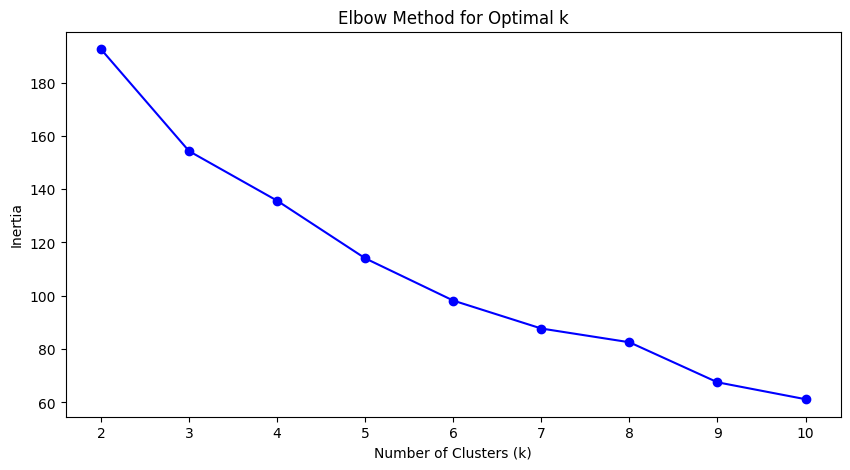

In [12]:
plt.figure(figsize=(10, 5))
plt.plot(K, inertia, 'bo-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.show()

### Plot Silhouette Scores

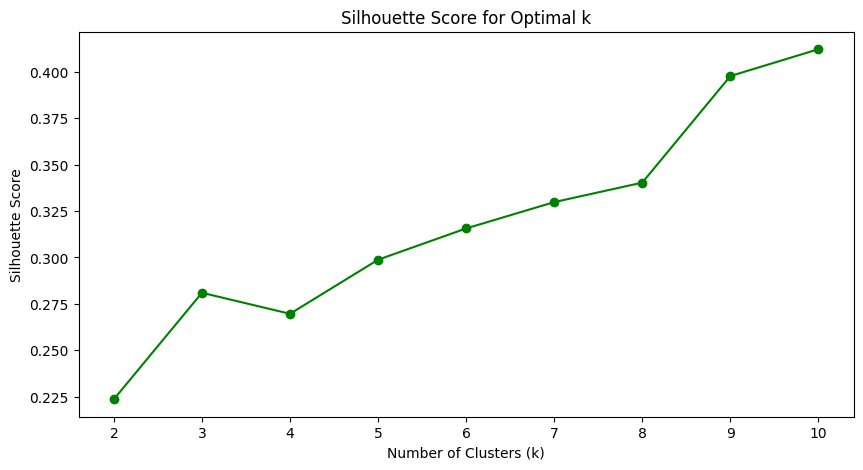

In [13]:
plt.figure(figsize=(10, 5))
plt.plot(K, silhouette_scores, 'go-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for Optimal k')
plt.show()

### Plot Davies-Bouldin Index


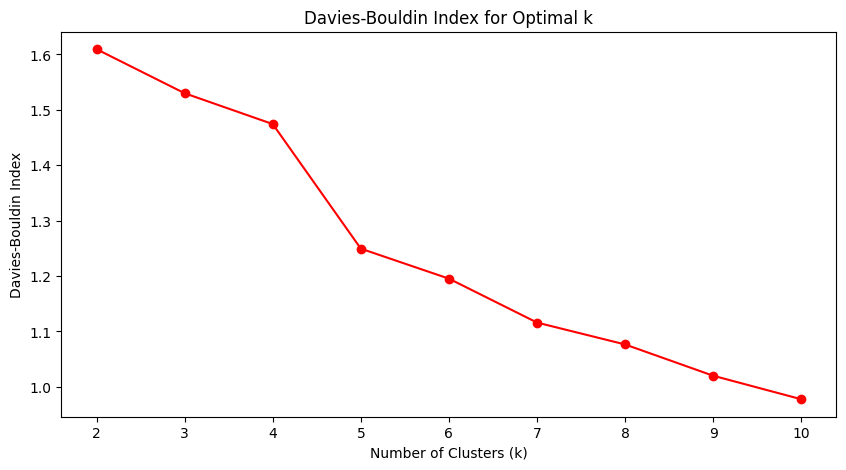

In [14]:
plt.figure(figsize=(10, 5))
plt.plot(K, db_indices, 'ro-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Davies-Bouldin Index')
plt.title('Davies-Bouldin Index for Optimal k')
plt.show()

### Choose optimal k

In [15]:
optimal_k = 10
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
kmeans.fit(X)

KMeans(n_clusters=10, random_state=42)

In [16]:
customer_features['Cluster'] = kmeans.labels_

### Evaluate clustering

In [17]:
db_index = davies_bouldin_score(X, kmeans.labels_)
silhouette_avg = silhouette_score(X, kmeans.labels_)
print(f"Davies-Bouldin Index: {db_index:.4f}")
print(f"Silhouette Score: {silhouette_avg:.4f}")

Davies-Bouldin Index: 0.9777
Silhouette Score: 0.4121


### Visualize clusters using PCA (2D)

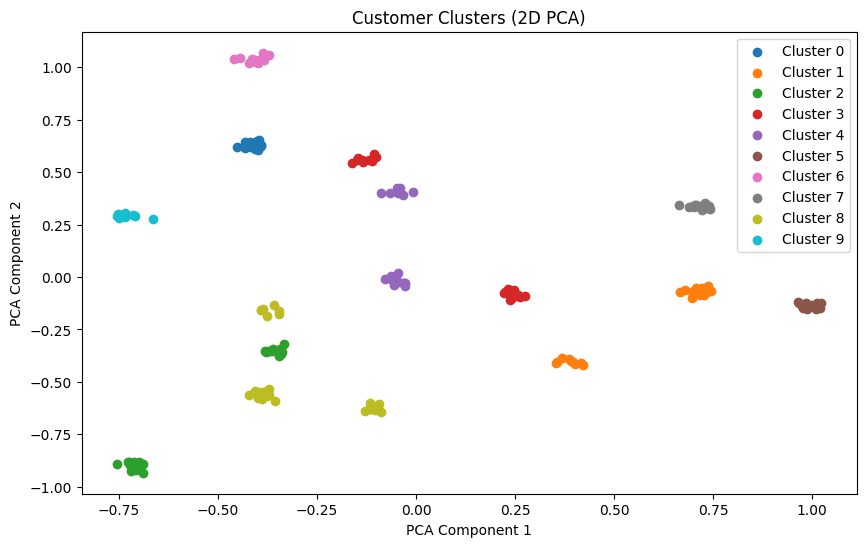

In [18]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

plt.figure(figsize=(10, 6))
for cluster in range(optimal_k):
    plt.scatter(X_pca[customer_features['Cluster'] == cluster, 0],
                X_pca[customer_features['Cluster'] == cluster, 1],
                label=f'Cluster {cluster}')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('Customer Clusters (2D PCA)')
plt.legend()
plt.show()

### Summary of clusters

In [19]:
cluster_summary = customer_features.groupby('Cluster').agg(
    TotalSpending=('TotalSpending', 'mean'),
    TransactionCount=('TransactionCount', 'mean'),
    AvgTransactionValue=('AvgTransactionValue', 'mean'),
    AvgProductPrice=('AvgProductPrice', 'mean')
).reset_index()
print(cluster_summary)

   Cluster  TotalSpending  TransactionCount  AvgTransactionValue  \
0        0       0.310609          0.382353             0.510350   
1        1       0.360386          0.430000             0.511869   
2        2       0.293852          0.415385             0.437918   
3        3       0.348145          0.410000             0.542024   
4        4       0.269483          0.347619             0.472294   
5        5       0.331345          0.393750             0.513386   
6        6       0.298908          0.342857             0.506224   
7        7       0.318334          0.407692             0.448530   
8        8       0.333184          0.450000             0.482684   
9        9       0.295810          0.360000             0.431290   

   AvgProductPrice  
0         0.507165  
1         0.525424  
2         0.475705  
3         0.559714  
4         0.490495  
5         0.515243  
6         0.493301  
7         0.445679  
8         0.518707  
9         0.470536  
